### Import libraries and dataset

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import re


dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-06 16:49:12.646442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 16:49:12.646491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 16:49:12.678302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 16:49:12.746511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

### Create vgg19 dataset

In [5]:
# Load pre-trained VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, pooling='avg')

2023-12-06 16:49:38.305168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 16:49:38.433820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 16:49:38.433893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 16:49:38.435845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 16:49:38.435901: I external/local_xla/xla/stream_executor

In [7]:
# Initialize new array
data = np.empty((len(dataset_array), 1+7+512))  # VGG19 output size is 512

# Iterate over each row in the dataset
for i in range(len(dataset_array)):
    # Load image
    img_path = dataset_processed_path + str(dataset_array[i,0].astype(int)) + '.jpg'
    img = Image.open(img_path)
    img = img.resize((224, 224))  # VGG19 expects 224x224 images
    img_data = kimage.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    # Compute global descriptor
    vgg19_feature = vgg19.predict(img_data)

    # Store data
    data[i,0] = dataset_array[i,0]
    data[i,1:8] = dataset_array[i,1:8]
    data[i,8:] = vgg19_feature.squeeze()

# Save data
np.save(dataset_processed_path + 'vgg19.npy', data)

1/1 [==============================] - 0s 93ms/step


### Plot positions of filtered dataset

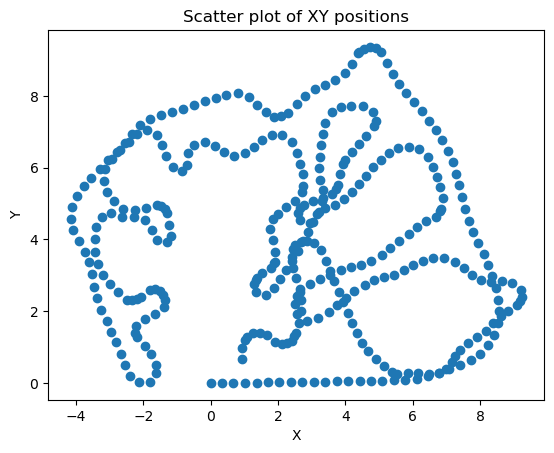

In [4]:
vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
positions = vgg19_dataset[:, 1:3]

# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

# Image Retrieval

### TEST 1

1/1 [==============================] - 0s 136ms/step


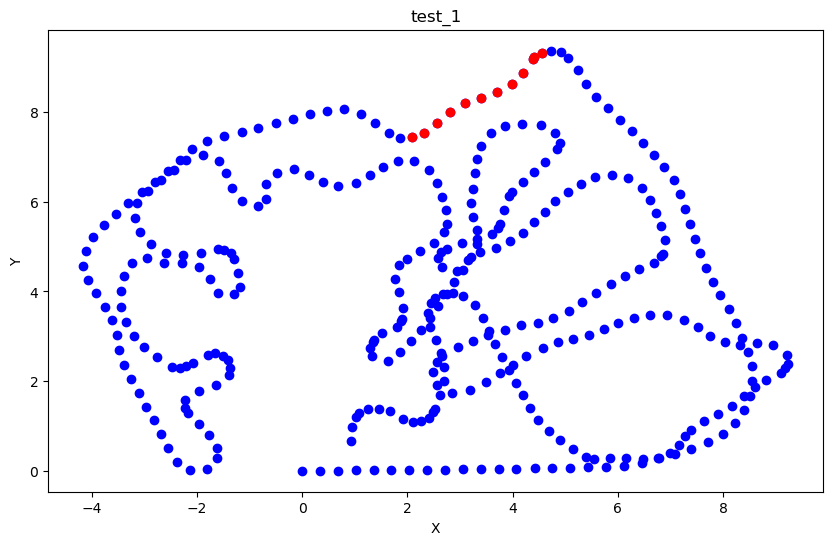

In [10]:
filter = True
N = 10
test = 'test_1'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples = 3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()

### TEST 2

1/1 [==============================] - 0s 137ms/step


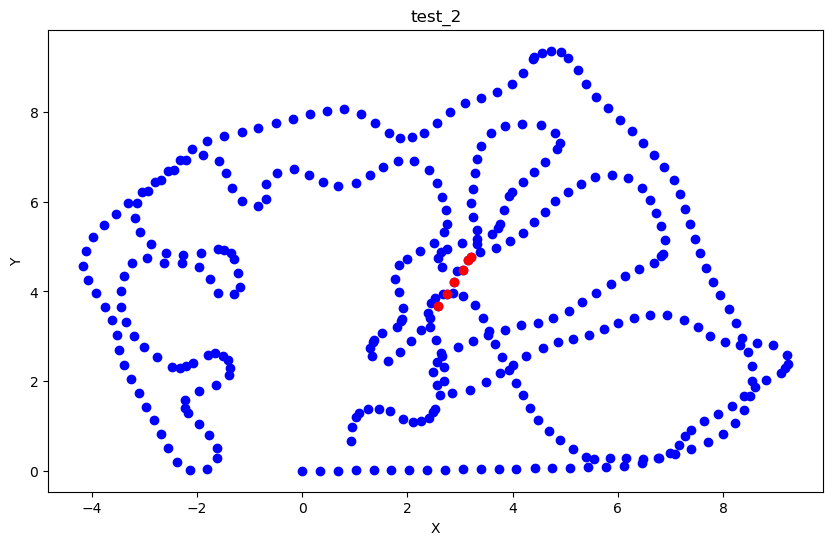

In [11]:
filter = True
N = 10
test = 'test_2'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples = 3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()

### TEST 3

1/1 [==============================] - 0s 100ms/step


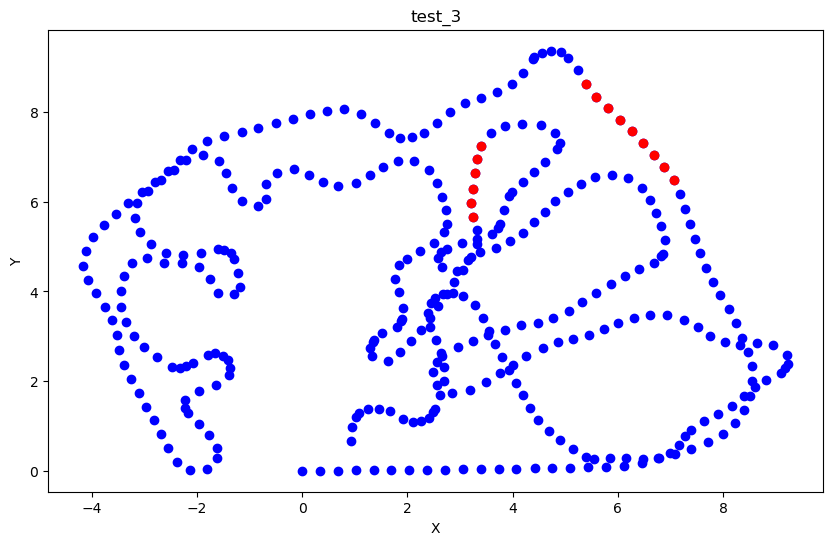

In [14]:
filter = True
N = 10
test = 'test_3'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate vgg19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))

all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples = 3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()

### TEST 4

1/1 [==============================] - 0s 15ms/step
2


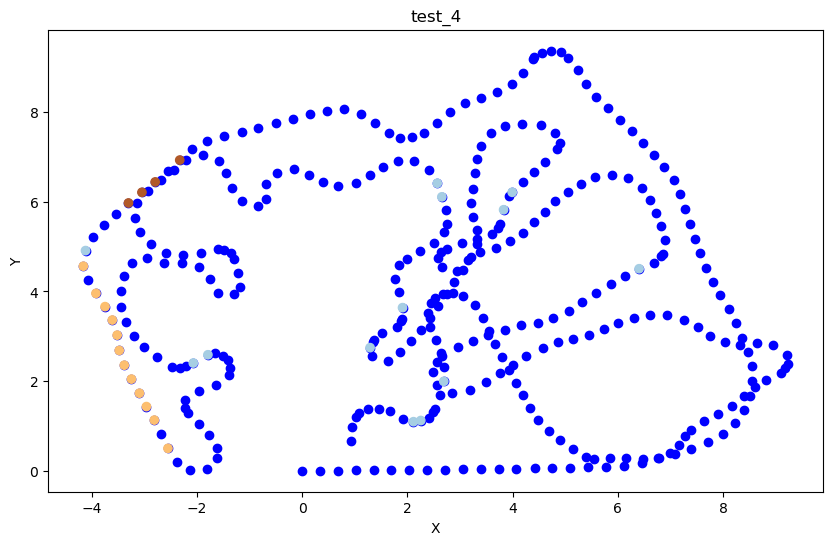

In [13]:
filter = True
N = 10
test = 'test_4'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate vgg19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))

all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.8, min_samples=4).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

print(max(clustering.labels_)+1)
# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(all_top_positions[:, 0], all_top_positions[:, 1], c=clustering.labels_, cmap='Paired')
#plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()

### TEST 5

1/1 [==============================] - 0s 16ms/step
2


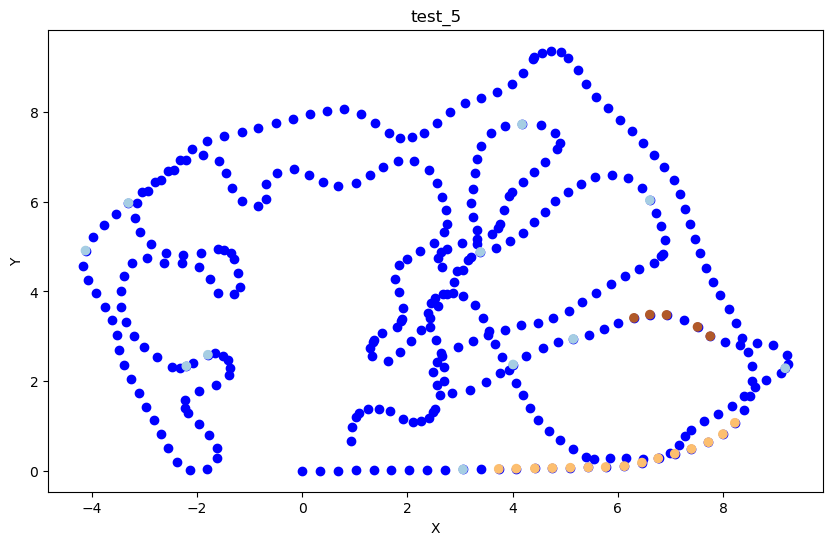

In [11]:
filter = True
N = 10
test = 'test_5'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate vgg19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))

all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

print(max(clustering.labels_)+1)
# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(all_top_positions[:, 0], all_top_positions[:, 1], c=clustering.labels_, cmap='Paired')
#plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()

### TEST 6

1/1 [==============================] - 0s 97ms/step
3


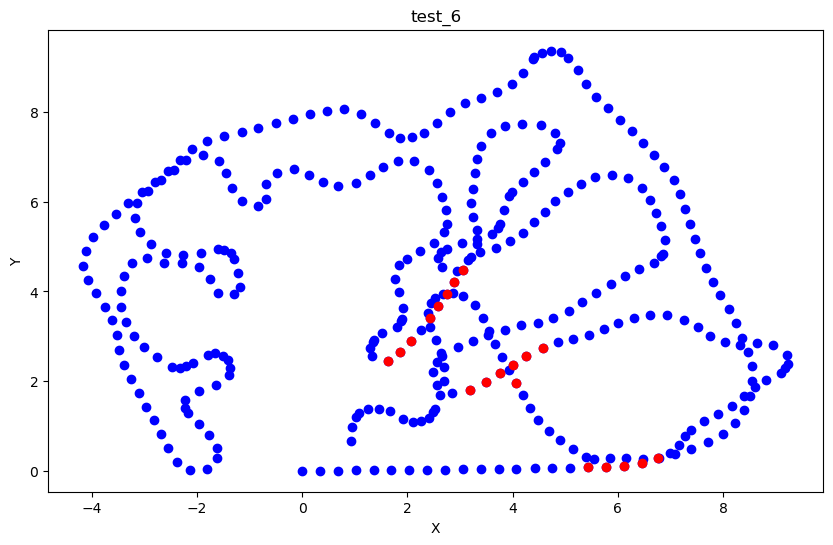

In [40]:
filter = True
N = 10
test = 'test_6'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate vgg19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))

all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

print(max(clustering.labels_)+1)
# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
#plt.scatter(all_top_positions[:, 0], all_top_positions[:, 1], c=clustering.labels_, cmap='Paired')
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()

### TEST 7

1/1 [==============================] - 0s 14ms/step
0


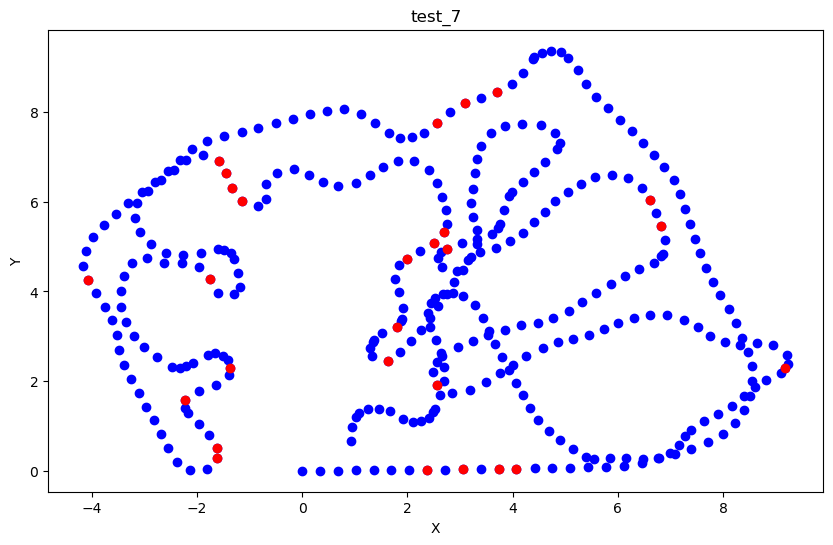

In [7]:
filter = False
N = 10
test = 'test_7'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate vgg19 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = vgg19.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg19_feature - vgg19) for vgg19 in vgg19_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg19_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))

all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

print(max(clustering.labels_)+1)
# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
#plt.scatter(all_top_positions[:, 0], all_top_positions[:, 1], c=clustering.labels_, cmap='Paired')
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test}')
plt.show()